# Project Three: Likelihood of Pregnancy based on Race and Age

The project is to predict if there is a significant likelihood of pregnancy based on the race and age of a unmarried woman based on US data from 2006-2015.


In [66]:
import os
try:
    inputFunc = raw_input
except NameError:
    inputFunc = input

import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
import numpy as np
 
import seaborn as sns
from statsmodels.formula.api import ols

from sklearn import linear_model
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from patsy import dmatrices

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

import random


def evaluate(pred, labels_test):
    acc = accuracy_score(pred, labels_test)
    print ("Accuracey: %s"%acc)
    tn, fp, fn, tp = confusion_matrix(labels_test, pred).ravel()

    recall = tp / (tp + fp)
    percision = tp / (tp + fn)
    f1 = (2 / ((1/recall)+(1/percision)))

    print ("")
    print ("True Negatives: %s"%tn)
    print ("False Positives: %s"%fp)
    print ("False Negatives: %s"%fn)
    print ("True Positives: %s"%tp)
    print ("Recall: %s"%recall)
    print ("Precision: %s"%percision)
    print ("F1 Score: %s"%f1)

def plot_bound(Z_val,data,col1,col2,binary):

    x_min = float(data.iloc[:,[col1]].min())-float(data.iloc[:,[col1]].min())*0.10 
    x_max = float(data.iloc[:,[col1]].max()+float(data.iloc[:,[col1]].min())*0.10)
    y_min = 0.0; 
    y_max = float(training.iloc[:,[col2]].max())+float(training.iloc[:,[col2]].max())*0.10
    h_x = (x_max-x_min)/100  # step size in the mesh
    h_y = (y_max-y_min)/100  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h_x), np.arange(y_min, y_max, h_y))
    if binary == 1:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])   
        Z = np.where(Z=="Y",1,0)
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    Z = Z.reshape(xx.shape)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.pcolormesh(xx, yy, Z)
    plt.show()

## Data Cleaning

I retrieved this data from data.gov. That is, we are trying to make a table with one **target** column and one or more **features**. Here I'm loading an edited version of unmarried_woman.csv from: https://catalog.data.gov/dataset/nonmarital-birth-rates-by-race-and-hispanic-origin-for-women-aged-15-44-united-states-1970


In [67]:
# Load and peek at your data. Change the file name as needed. 
raw_data_df = pd.read_csv('unmarried_woman.csv', parse_dates=[0]) 
raw_data_df.head()

,Year,Age,Race,Birth_Rate
0,2015-01-01,15-19 years,All Races,20.2
1,2015-01-01,15-19 years,Asian or Pacific Islander total,5.5
2,2015-01-01,15-19 years,Black total,31.5
3,2015-01-01,15-19 years,Hispanic,31.6
4,2015-01-01,15-19 years,Non-Hispanic white,13.9


In [68]:
# You can explore unique entires by stating the column and using .unique() like this:
print(raw_data_df["Age"].unique())
print(raw_data_df["Race"].unique())
print(raw_data_df["Birth_Rate"].unique())

['15-19 years' '20-24 years' '25-29 years' '30-34 years' '35-39 years'
 '40-44 years']
['All Races' 'Asian or Pacific Islander total' 'Black total' 'Hispanic'
 'Non-Hispanic white' 'White total']
[  20.2    5.5   31.5   31.6   13.9   18.8   22.     6.2   34.4   15.
   20.3   24.     7.2   38.5   37.6   16.2   21.9   26.7    8.1   43.4
   41.8   17.8   24.1   28.4    8.6   46.7   44.7   25.5   31.1    9.2
   50.8   50.    27.9   34.    10.6   55.9   56.7   21.8   30.4   35.9
   11.4   59.7   62.4   22.5   31.9   36.5   11.9   61.3   65.4   22.6
   32.3   35.5   12.    61.1   65.9   21.6   17.9   94.2   87.9   43.3
   54.6   61.6   19.4   97.4   92.3   44.4   63.1   20.7  100.7   93.1
   45.6   56.9   64.7  103.5   96.5   46.6   58.3   66.7   22.3  106.9
  100.6   47.8   60.1   70.    23.2  112.6  110.5   49.5   63.4   74.4
   25.3  119.5  125.4   51.4   67.3   78.1   26.4  124.   141.    52.9
   70.9   79.8   27.1  125.3  153.8   53.4   72.6   79.1   26.8  125.5
  155.1   52.6   71.7   

In [69]:
# You can explore rows with a specific value like so
raw_data_df[raw_data_df["Age"]=='20-24 years'].head() # remove .head() to see all entires

,Year,Age,Race,Birth_Rate
60,2015-01-01,20-24 years,All Races,59.7
61,2015-01-01,20-24 years,Asian or Pacific Islander total,17.9
62,2015-01-01,20-24 years,Black total,94.2
63,2015-01-01,20-24 years,Hispanic,87.9
64,2015-01-01,20-24 years,Non-Hispanic white,43.3


In [70]:
# You can count the number of rows like so
print("Size of entire table: %s "%len(raw_data_df))
print("Size of entires matching filter: %s "%len(raw_data_df[raw_data_df["Age"]=="20-24 years"]))

Size of entire table: 360 
Size of entires matching filter: 60 


In [71]:
raw_data_df.loc[raw_data_df['Age'] == '15-19 years', 'Age'] = 18
raw_data_df.loc[raw_data_df['Age'] == '20-24 years', 'Age'] = 21
raw_data_df.loc[raw_data_df['Age'] == '25-29 years', 'Age'] = 26
raw_data_df.loc[raw_data_df['Age'] == '30-34 years', 'Age'] = 30
raw_data_df.loc[raw_data_df['Age'] == '35-39 years', 'Age'] = 35
raw_data_df.loc[raw_data_df['Age'] == '40-44 years', 'Age'] = 42
raw_data_df.loc[raw_data_df['Race'] == 'All Races', 'Race'] = 1
raw_data_df.loc[raw_data_df['Race'] == 'Asian or Pacific Islander total', 'Race'] = 2
raw_data_df.loc[raw_data_df['Race'] == 'Black total', 'Race'] = 3
raw_data_df.loc[raw_data_df['Race'] == 'Hispanic', 'Race'] = 4
raw_data_df.loc[raw_data_df['Race'] == 'Non-Hispanic white', 'Race'] = 5
raw_data_df.loc[raw_data_df['Race'] == 'White total', 'Race'] = 6
raw_data_df.head()


,Year,Age,Race,Birth_Rate
0,2015-01-01,18,1,20.2
1,2015-01-01,18,2,5.5
2,2015-01-01,18,3,31.5
3,2015-01-01,18,4,31.6
4,2015-01-01,18,5,13.9


In [72]:
# I created a new column to measure the likelihood of pregnancy.
raw_data_df["Pregnant"] = "N"
raw_data_df.head()

,Year,Age,Race,Birth_Rate,Pregnant
0,2015-01-01,18,1,20.2,N
1,2015-01-01,18,2,5.5,N
2,2015-01-01,18,3,31.5,N
3,2015-01-01,18,4,31.6,N
4,2015-01-01,18,5,13.9,N


In [78]:
# Here I modified the column to gauge if the birth rate was over 80. If so, it would be noted as likely.
raw_data_df.loc[raw_data_df['Birth_Rate'] > 50, 'Pregnant'] = "Y"
raw_data_df.head()

,Year,Age,Race,Birth_Rate,Pregnant
0,2015-01-01,18,1,20.2,N
1,2015-01-01,18,2,5.5,N
2,2015-01-01,18,3,31.5,N
3,2015-01-01,18,4,31.6,N
4,2015-01-01,18,5,13.9,N


In [79]:
# I'm now going to make a set of tables to be used in training some models


In [80]:
# The set will be for classifiers where the target is a class.

pregnant_class_df = raw_data_df[[
                               'Pregnant', 
                               'Age',
                                'Race'
                               ]].copy()
pregnant_class_df.head()

,Pregnant,Age,Race
0,N,18,1
1,N,18,2
2,N,18,3
3,N,18,4
4,N,18,5


## Training and Validation

Above I created the dataset worth exploring: 

- **`pregnancy_class_df`**. The data needed to access *pregnancy likelihood* as a categorical variable.

## pregnant_class_df

Percentage of Ys: 0.4027777777777778



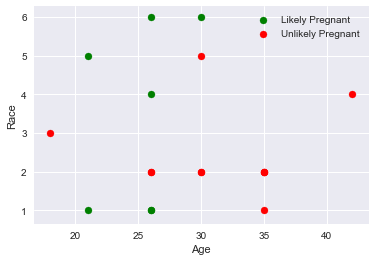

In [81]:
data = pregnant_class_df
holdout = data.sample(frac=0.05)
training = data.loc[~data.index.isin(holdout.index)]

# Define the target (y) and feature(s) (X)
features_train = training.drop("Pregnant", axis=1).as_matrix(columns=None)
labels_train = training["Pregnant"].as_matrix(columns=None)

features_test = holdout.drop( "Pregnant", axis=1).as_matrix(columns=None)
labels_test = holdout["Pregnant"].as_matrix(columns=None)

# What percentage of the time is target Y?
print("Percentage of Ys: %s\n"%(len(data[data["Pregnant"]=="Y"])/len(data)))

#### initial visualization
feature_1_no = [features_test[ii][0] for ii in range(0, len(features_test)) if labels_test[ii]=="N"]
feature_2_no = [features_test[ii][1] for ii in range(0, len(features_test)) if labels_test[ii]=="N"]
feature_1_yes = [features_test[ii][0] for ii in range(0, len(features_test)) if labels_test[ii]=="Y"]
feature_2_yes = [features_test[ii][1] for ii in range(0, len(features_test)) if labels_test[ii]=="Y"]
plt.scatter(feature_1_yes, feature_2_yes, color = "g", label="Likely Pregnant")
plt.scatter(feature_1_no, feature_2_no, color = "r", label="Unlikely Pregnant")
plt.legend()
plt.xlabel("Age")
plt.ylabel("Race")
plt.show()


Logistic Regression
Accuracey: 0.666666666667

True Negatives: 11
False Positives: 0
False Negatives: 6
True Positives: 1
Recall: 1.0
Precision: 0.142857142857
F1 Score: 0.25


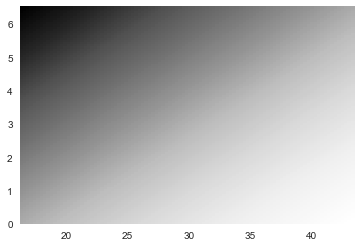


Y
1.0


Decision Tree
Accuracey: 0.944444444444

True Negatives: 11
False Positives: 0
False Negatives: 1
True Positives: 6
Recall: 1.0
Precision: 0.857142857143
F1 Score: 0.923076923077


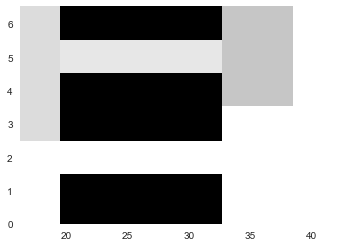

Random Forest
Accuracey: 0.888888888889

True Negatives: 10
False Positives: 1
False Negatives: 1
True Positives: 6
Recall: 0.857142857143
Precision: 0.857142857143
F1 Score: 0.857142857143


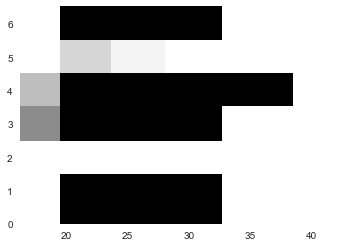

SVM
Accuracey: 0.944444444444

True Negatives: 11
False Positives: 0
False Negatives: 1
True Positives: 6
Recall: 1.0
Precision: 0.857142857143
F1 Score: 0.923076923077


In [82]:
# Logistic Regression
model = LogisticRegression(fit_intercept = False, C = 1e9)
clf = model.fit(features_train, labels_train)
pred = clf.predict(features_test)
print("Logistic Regression")
evaluate(pred, labels_test)  
plot_bound("Y",holdout,1,2,0)


# Test some spot
x_test = 70
y_test = 16000
print("")
print(clf.predict([[x_test,y_test]])[0])
print(clf.predict_proba([[x_test,y_test]])[0][1])
print("")

from sklearn import tree
clf = tree.DecisionTreeClassifier(min_samples_split=40)
clf = clf.fit(features_train, labels_train)
pred = clf.predict(features_test)
print("\nDecision Tree")
evaluate(pred, labels_test)
plot_bound("Y",holdout,1,2,0)



from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf = clf.fit(features_train, labels_train)
pred = clf.predict(features_test)
print("Random Forest")
evaluate(pred, labels_test)  
plot_bound("Y",holdout,1,2,0)


from sklearn.svm import SVC
clf = SVC(kernel="rbf",probability=True)
clf = clf.fit(features_train, labels_train)
pred = clf.predict(features_test)
print("SVM")
evaluate(pred, labels_test)  
#plot_bound("Y",holdout,1,2,0) # plot doesn't work with SVM

## Result analysis

Based on the result, the accuracy was accurate... However...